In [2]:
import scipy.stats as sps 
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

> 📈 **Задача**
>
> Мы думаем покупать рекламу в поисковике яндекса при поиске "недвижимость в Москве". Авито показывается без рекламы в поиске на 2 месте, а конкурент на 1 месте. Мы же хотим купить первое место в выдаче. Мы посчитали, что если конверсия в показ на первом месте будет больше 70%, то мы значительно усилим наши позиции на рынке и заберем крупную часть трафика у конкурента. И такую рекламу стоит покупать. На первое время мы решили купить рекламу на 10 дней и на основании данных принять решение о продлении покупки рекламы. Но есть вопрос: правда ли, что 10 дней нам подойдут? Может можно меньше? Или надо больше?
>
> Допущение: представим, что в день "недвижимость в Москве" ищут 1000 человек, и ни один юзер не задает запрос про конкурентов дважды

Чтобы решить эту задачу, надо переформулировать ее на языке математики:
- Пусть $p$ &mdash; истинный параметр конверсии. Тогда наша гипотеза звучит так: 
    - $H_0: p = 0.7\ vs.\ H_1: p > 0.7$
    - Нас устраивает ошибка первого рода в 5%.
- Какой критерий использовать?
    - Рассмотрим статистику  $T(X^n) = \underset{i=1}{\overset{n}{\sum}} X_i,\ T \overset{H_0}{\sim} \text{Binom} (n, p_0)$, где  $X_i$ &mdash; конверсия i-ого пользователя. $n = 10 * 1000$.
    - Когда мы отвергнем поставленную гипотезу?
        - Пусть реализация $T(X^n) = t$. Тогда если $P_{H_0}(T(X^n) \geq t) \leq \alpha$, то мы отвергнем гипотезу.
        $$
        \begin{align}
            &P_{H_0}(T(X^n) \geq t) \leq \alpha \Leftrightarrow\\
            &1 - P_{H_0}(T(X^n) < t) \leq \alpha \Leftrightarrow\\
            & P_{H_0}(T(X^n) < t) = P_{H_0}(T(X^n) \leq t - 1) \geq 1 - \alpha \Leftrightarrow\\
            &F_{\text{Binom}(n, p_0)}(t - 1) \geq 1 - \alpha \Leftrightarrow\\
            &t \geq F^{-1}(1 - \alpha) + 1
        \end{align}
        $$
        Чтобы найти начало крит. области, найдо найти мин t, чтобы $F(x) \geq p$. Вспомним определение квантили: $u_p = \{\min\ x: F(x) \geq p \}$. Тогда это и есть искомое значение: начало критической области.
    - `reject_value = sps.binom(p=p0, n=n).ppf(1 - alpha) + 1`. У нас есть правило для отвержения гипотезы
- Теперь ответим математически на вопрос: стоит ли 10 дней держать рекламу или нет? Это зависит в первую очередь от MDE (Minimum Detectible Effect):
    - Если MDE большой, то слишком мало. Например, MDE при мощности 80% равен 20%. то есть только если конверсия будет 90%, то мы задетектируем эффект. Это нам не подходит, мы ничего таким образом не обнаружим.
    - Если MDE слишком маленький, то мы долго держим тест. Например, MDE равен 0.01%. Нам такая точность не нужна, а значит мы переплатим за проверку гипотезы.
- Как посчитать MDE?
    - Нам надо найти $MDE=p - p_0$, такое, что:
        - если $T \overset{H_1}{\sim} \text{Binom} (n, p)$, то в $1-\beta$ проценте случаев для него отвергнется критерий. Проверяем мощность.
        - если $T \overset{H_0}{\sim} \text{Binom} (n, p_0)$, то критерий отвергнется для него в $\alpha$ процентее случаев. Проверяем FPR.
       

- Мы знаем, что нулевая гипотеза отвергается, если $T \geq \text{reject_value}$
- Тогда нам надо найти такое $p$, чтобы $P_{\text{Binom} (n, p)}(T(X^n) \geq \text{reject_value}) = 1-\beta$:
    $$\begin{align}
    &P_{\text{Binom} (n, p)}(T(X^n) \geq \text{reject_value}) \geq 1-\beta \Leftrightarrow\\
    &1 - P_{\text{Binom} (n, p)}(T(X^n) < \text{reject_value}) \geq 1 - \beta \Leftrightarrow\\
    &P_{\text{Binom} (n, p)}(T(X^n) \leq \text{reject_value} - 1) \leq \beta
    \end{align}
    $$
    То есть мы ищем такое p, что `sps.binom(p=p, n=N).cdf(reject_value - 1) <= beta`
- Какую мощность использовать?
    - Чаще всего используют 80%: в 4 из 5 случаев мы найдем эффект, если он будет.

In [11]:
p0 = 0.7 
days = 10
alpha=0.05
power=0.8
people_per_day = 1000
N = days * people_per_day

def get_reject_value(p0, size, alpha):
    right_bound = (sps.binom(p=p0, n=size).ppf(1 - alpha) + 1)
    return right_bound

# Находим область для отвержения
reject_value = get_reject_value(p0, N, alpha)

# Перебираем в цикле значения p при корректности H_1
for p in np.arange(0.7, 1.001, 0.001):
    # Проверяем мощность
    if sps.binom(p=p, n=N).cdf(reject_value - 1) <= 1 - power:
        print(f"p={round(p * 100, 1)}%, MDE={round((p - p0) * 100, 1)}%")
        break

p=71.2%, MDE=1.2%


In [12]:
reject_value

7076.0

Отлично, наш MDE=1.2%. Но понимаем, что это очень маленький. MDE: нас устроит и MDE=3%. Сколько в этом случае держать тест?

Давайте для каждого числа days в цикле:
- Посчитаем число юзеров в эксперименте
- Построим критерий, а точнее найдем `reject_value`
- Найдем p, начиная с которого мощность становится больше 80%.
- посчитаем MDE
- Если MDE не больше 3%, мы останавливаемся  и выводим ответ. Иначе продолжаем.

In [13]:
p0 = 0.7 
alpha=0.05
power=0.8
people_per_day = 1000

def find_min_number_of_days(MDE, p0, people_per_day, alpha, power):
    N = 0
    #Для каждого числа days в цикле:
    for days in range(1, 10):
        #Посчитаем число юзеров в эксперименте
        N += people_per_day
        # Находим область для отвержения
        reject_value = get_reject_value(p0, N, alpha)
        for p in np.arange(0, 1.001, 0.001):
            # Проверяем мощность
            if sps.binom(p=p, n=N).cdf(reject_value - 1) <= 1 - power:
                # Проверяем MDE
                if p - p0 <= MDE:
                    return days


days = find_min_number_of_days(MDE=0.03, p0=0.7, people_per_day=1000, alpha=0.05, power=0.8)
print(f'days: {days}')

days: 2


In [14]:
N = days * people_per_day
reject_value = get_reject_value(p0, N, alpha)

for p in np.arange(0.7, 0.9, 0.001):
    if sps.binom(p=p, n=N).cdf(reject_value - 1) <= 1 - power:
        print(f"p={round(p * 100, 1)}%, MDE={round((p - p0) * 100, 1)}%")
        break

p=72.6%, MDE=2.6%


А значит мы могли купить рекламу всего на 2 дня.

## Визуализация MDE, не имеющая прямой связи с задачей

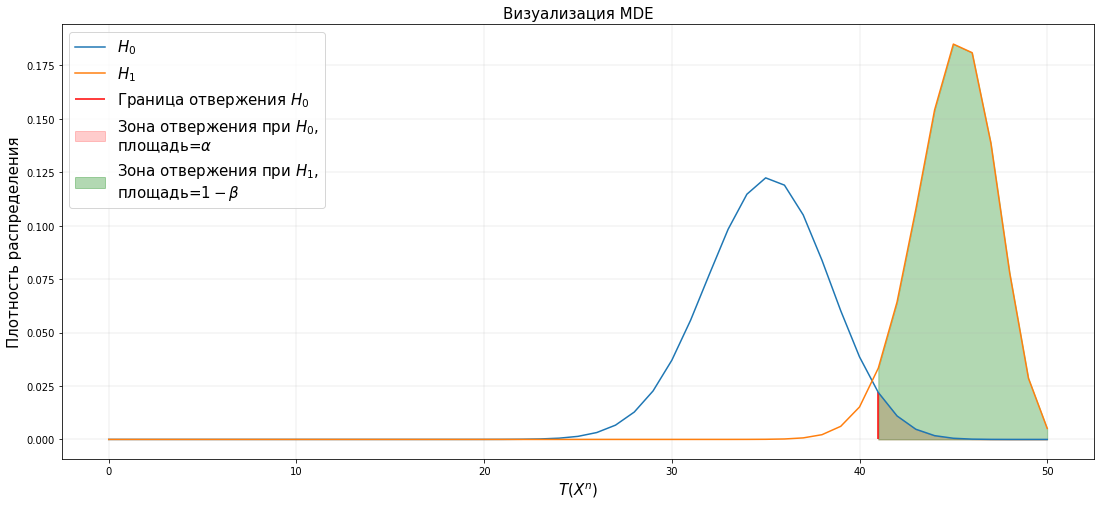

In [3]:
p0 = 0.7 
alpha=0.05
power=0.8
N = 50

def get_reject_value(p0, size, alpha):
    right_bound = (sps.binom(p=p0, n=size).ppf(1 - alpha) + 1)
    return right_bound

x = np.arange(0, N + 1, 1)
reject_value = get_reject_value(p0, N, alpha)

h0_distr = sps.binom(p=0.7, n=N)
h1_distr = sps.binom(p=0.9, n=N)

plt.figure(figsize=(18.5, 8))
plt.title('Визуализация MDE', fontsize=15)
plt.plot(x, h0_distr.pmf(x), label='$H_0$')
plt.plot(x, h1_distr.pmf(x), label='$H_1$')
x1 = x[x>=reject_value]

plt.vlines(reject_value, 0, h0_distr.pmf(reject_value), 
               color='red', label="Граница отвержения $H_0$")

plt.fill_between(x1, 0, h0_distr.pmf(x1), 
               color='red', alpha=0.2, label="Зона отвержения при $H_0$,\nплощадь=$\\alpha$")
plt.fill_between(x1, 0, h1_distr.pmf(x1), 
               color='green', alpha=0.3, label="Зона отвержения при $H_1$,\nплощадь=$1-\\beta$")
plt.legend(fontsize=15)
plt.xlabel('$T(X^n)$', fontsize=15)
plt.ylabel('Плотность распределения', fontsize=15)
plt.grid(linewidth=0.2)

plt.show()